# Predicting review outcomes of products basing on review text
## Artificial Neural Network is applied to written reviews in order to determine what is their outcome - whether they are negative, neutral or positive
## Dataset is taken from http://jmcauley.ucsd.edu/data/amazon/

In [1]:
# Imports of general packages
import re
import os
import json
import nltk
import string
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Imports required for text processing
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Importing machine learning models, preprocessing tools and classifiers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing
## Importing libraries required for Artificial Neural Networks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout    
from keras.utils import to_categorical
from keras import optimizers
from keras import regularizers
from tensorflow import argmax
import tensorflow as tf
# Importing wordcloud module
from wordcloud import WordCloud

Using TensorFlow backend.


In [2]:
# Preventing sklearn warnings from displaying on screen
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
tf.logging.set_verbosity(tf.logging.ERROR)
# Setting CUDA_VISIBLE_DEVICES to -1 - it will ensure that tensorflow is run with CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
# Changing directory
os.chdir('E:\\google_disk\\doktorat\\programming\\predicting_ratings\\')

In [4]:
# Initializing list of reviews
reviews_list = []

In [5]:
# Reading 50 000 entries from file
with open('Cell_Phones_and_Accessories_5.json', 'r') as file:
        for line in file:
            if len(reviews_list) < 50000:
                reviews_list.append(json.loads(line))

In [6]:
# Printing the first entry
print(reviews_list[0])

{'reviewerID': 'A30TL5EWN6DFXT', 'asin': '120401325X', 'reviewerName': 'christina', 'helpful': [0, 0], 'reviewText': "They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again", 'overall': 4.0, 'summary': 'Looks Good', 'unixReviewTime': 1400630400, 'reviewTime': '05 21, 2014'}


In [7]:
# Converting reviews_list to pandas dataset
dataset = pd.io.json.json_normalize(reviews_list)

In [8]:
# Removing unnecessary content from the dataframe - only text and rating is preserved
dataset = dataset.drop('asin', 1).drop('helpful', 1).drop('reviewTime', 1).drop('reviewerID', 1).drop('reviewerName', 1).drop('summary', 1).drop('unixReviewTime', 1)

In [9]:
# Converting star ratings (which are very subjective) to positive, neutral and negative scores - it will make prediction easier, yet all informations will be preserved
# 0 will mean score was negative, 1 will mean score was neutral, 2 will mean score was positive
mapping={
        1: 0,
        2: 0,
        3: 1,
        4: 2,
        5: 2
        }
dataset['overall'] = dataset['overall'].map(mapping)

In [10]:
# Showing how many occurences of each score there are in the dataset
counts = dataset['overall'].value_counts()
print(f"In a given dataset:\n"
      f"There are {counts[2]} positive reviews\n"
      f"There are {counts[1]} neutral reviews\n"
      f"There are {counts[0]} negative reviews\n")

In a given dataset:
There are 36203 positive reviews
There are 5886 neutral reviews
There are 7911 negative reviews



In [11]:
# Reducing dataset size so that there is equal number of positive, neutral and negative reviews
# Number of neutral reviews is the smallest, thus other will cut to this length
neutral_reviews_count = counts[1]
counter_positive = 0
counter_negative = 0
for index, row in dataset.iterrows():
    if row['overall'] == 2:
        counter_positive += 1
        if counter_positive > neutral_reviews_count:
            dataset.drop(index, inplace=True)
    if row['overall'] == 0:
        counter_negative += 1
        if counter_negative > neutral_reviews_count:
            dataset.drop(index, inplace=True)
counts = dataset['overall'].value_counts()
print(f"After transforming, in a given dataset:\n"
      f"There are {counts[2]} positive reviews\n"
      f"There are {counts[1]} neutral reviews\n"
      f"There are {counts[0]} negative reviews\n")

After transforming, in a given dataset:
There are 5886 positive reviews
There are 5886 neutral reviews
There are 5886 negative reviews



In [12]:
# Defining lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
# Defining stopwords
stopwords = stopwords.words('english') + list(string.punctuation)

In [13]:
# Creating array with tokenized words
sentences_tokenized = []
# Creating array with scores
review_outcome = []

In [14]:
# Lemmatizing, getting rid of stopwords in the data and appending eveything to lists
for rating, text in dataset.itertuples(index=False):
    text = text.lower()
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [wordnet_lemmatizer.lemmatize(i) for i in tokens]
    tokens = [t for t in tokens if t not in stopwords]
    tokens = [t for t in tokens if len(t)>2]
    sentences_tokenized.append(tokens)
    review_outcome.append(rating)

In [15]:
# Creating list that will keep all of the words
all_words = []
# Creating a dictionary, in which number of occurences of each word will be stored
# - this is done in order to get rid of the words that are rare in dataset
words_count = {}

In [16]:
# Appending data to all_words list
for sentence in sentences_tokenized:
    for token in sentence:
        all_words.append(token)

In [17]:
# Counting occurence of each word and providing data to dictionary
for word in all_words:
    if word in words_count:
        words_count[word] += 1
        pass
    else:
        words_count[word] = 1

In [18]:
# Building a list which will store all of the words that are relevant; words are considered relevant if they appeared more than 20 times in the dataset
relevant_words = []
for key, value in words_count.items():
    if value > 20:
        relevant_words.append(key)

In [19]:
# Comparing all of the words and relevant words
print(f"Originally there were {len(words_count)} unique words in dataset but "
      f"only {len(relevant_words)} were anyhow meaningful.")

Originally there were 43181 unique words in dataset but only 3230 were anyhow meaningful.


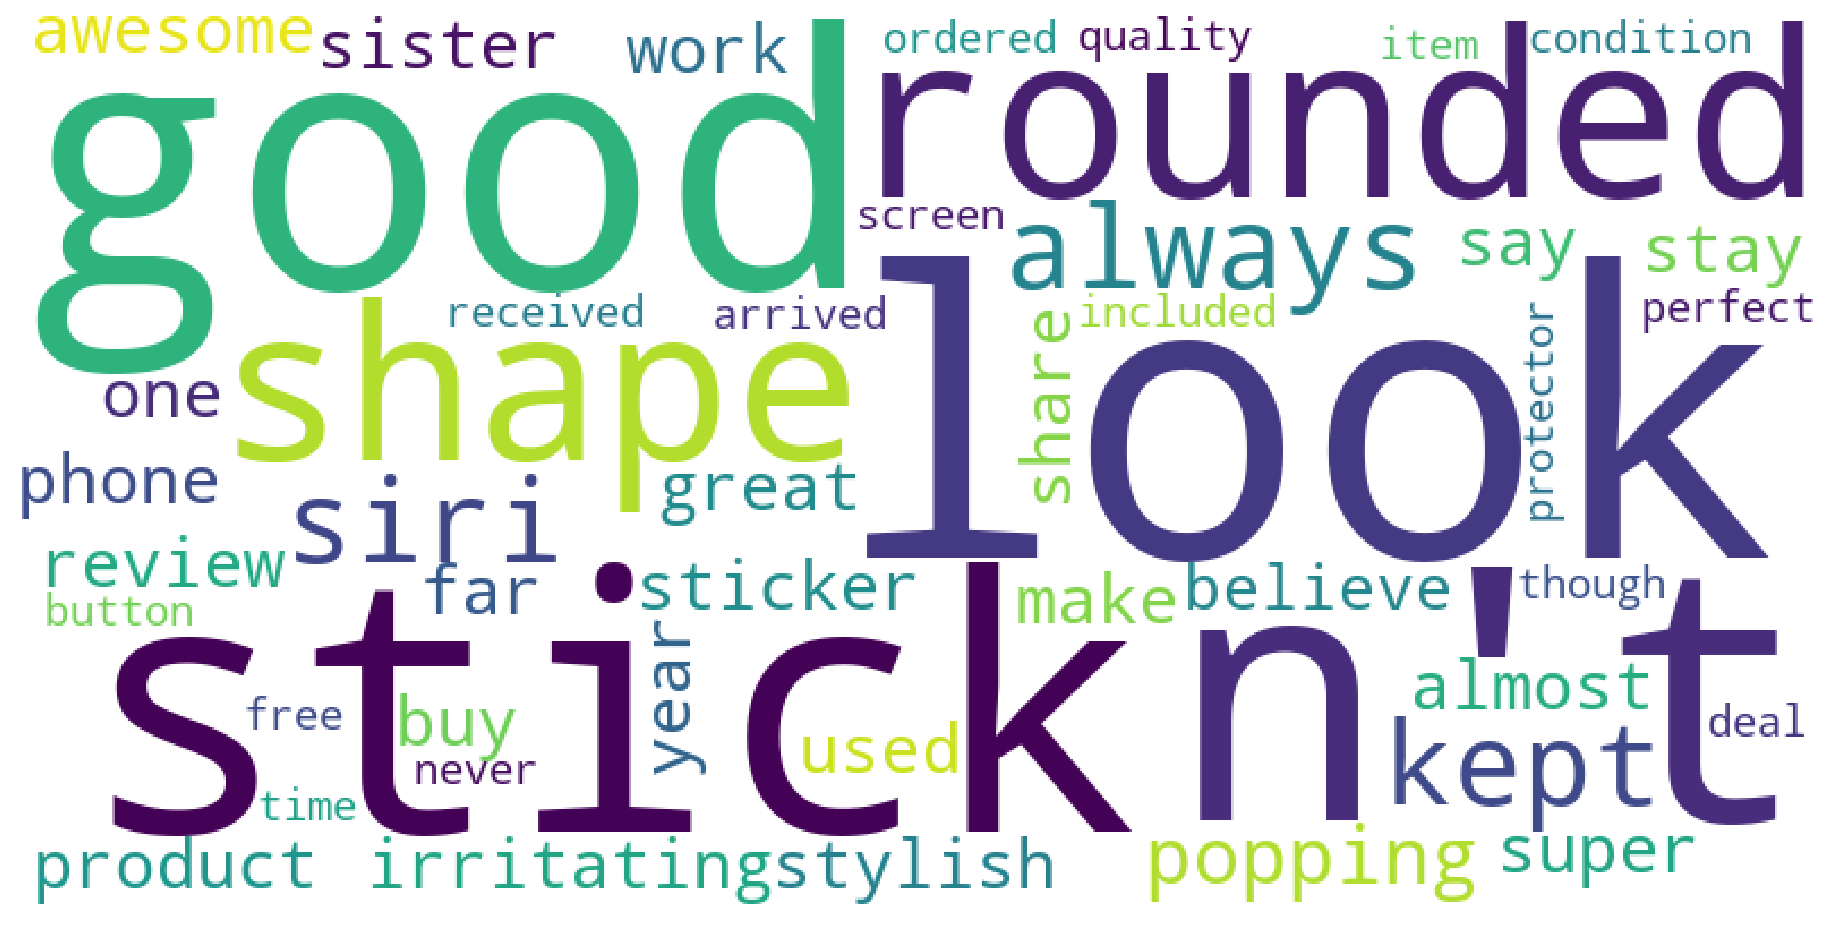

In [20]:
# Wordcloud from relevant words
wordcloud = WordCloud(max_words=50,background_color="white",width=800, height=400).generate(','.join(relevant_words[0:50]))
wordcloud.to_file('wordcloud.png')
plt.figure(dpi=150, figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [21]:
# Create a list with tokenized reviews that will contain only relevant wods
sentences_tokenized_relevant = []

In [22]:
# Getting rid of words that are not in relevant_words list
for sentence in sentences_tokenized:
    sentence = [word for word in sentence if word in relevant_words]
    sentences_tokenized_relevant.append(sentence)

In [23]:
# Creating list that will containg tokenized words and score   
zipped_list = list(zip(sentences_tokenized_relevant, review_outcome))    
data = pd.DataFrame(zipped_list, columns = ['text', 'label'])

In [24]:
# Printing the each tokenized word in the first review
print(sentences_tokenized[0])

['look', 'good', 'stick', 'good', "n't", 'like', 'rounded', 'shape', 'always', 'bumping', 'siri', 'kept', 'popping', 'irritating', "n't", 'buy', 'product', 'like']


In [25]:
# Converting list of lists that contain tokenized words grouped in list that 
# contain sentences, into a single list that contains full sentences
individual_sentences_tokenized = []
for x in range(0, len(sentences_tokenized)):
    a = ', '.join(sentences_tokenized[x])
    a = a.replace(',', '')
    individual_sentences_tokenized.append(a)

In [26]:
# Printing the first tokenized sentence
print(individual_sentences_tokenized[0])

look good stick good n't like rounded shape always bumping siri kept popping irritating n't buy product like


In [27]:
# Converting list into pandas series
tokenized_sentences_series = pd.Series(individual_sentences_tokenized)
review_outcome_series = pd.Series(review_outcome)

In [28]:
# Assigning X and Y which will make it more clear what is fed to the model
X = tokenized_sentences_series
Y = review_outcome_series

In [29]:
# Splitting train and test data - it is called train_data and test_data because
# not relevant data will be removed from the model
train_data, test_data, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [30]:
# Using CountVectorizer for feature extraction
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data)

In [31]:
# Using TfidfTransformer for normalizing results of CountVectorizer
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train)

In [32]:
# Transforming test set accordingly to train set results
X_test = vectorizer.transform(test_data)
X_test = transformer.transform(X_test)

In [33]:
# Defining classifiers readily available from sklearn library
simple_models = [LogisticRegression, RandomForestClassifier, DecisionTreeClassifier]

In [34]:
# Applying classifiers that are readily available from sklearn
for x in simple_models:
    model = x()
    model.fit(X_train, y_train)
    print(f"Model: {x.__name__}\nTrain set accuracy: {model.score(X_train, y_train)}\nTest set accuracy: {model.score(X_test, y_test)}\n")

Model: LogisticRegression
Train set accuracy: 0.7711427133148754
Test set accuracy: 0.67440543601359

Model: RandomForestClassifier
Train set accuracy: 0.9903095897306821
Test set accuracy: 0.5543601359003397

Model: DecisionTreeClassifier
Train set accuracy: 0.999433677321923
Test set accuracy: 0.4830124575311438



In [35]:
# Since Keras requires that data is one-hot encoded, such transformation is applied
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [36]:
# Getting number of dimensions of X_train after transformation (it must be supplied to the first node in ANN)
input_dim = X_train.shape[1]

In [37]:
# Lowering the default learning rate of the optimizer to limit overfitting
adam = optimizers.adam(lr=0.0001)

In [38]:
# Defining Artificial Neural Network; this ANN is built with 2 deep layers and 1 output layer;
# in order to avoid overfitting, deep layers have a dropout rate of 0.4; all layers
# have updating weights regularized; all layers also have activation function updates
# regularized; this all is done to prevent overfitting 
classifier = Sequential()
classifier.add(Dense(20, input_dim=input_dim, activation='relu', bias_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
classifier.add(Dropout(rate=0.4))
classifier.add(Dense(20, activation='relu', bias_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
classifier.add(Dropout(rate=0.4))
classifier.add(Dense(3, activation='softmax', bias_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))

In [39]:
# For multi-variable categorical classification, categorical crossentropy is the optimal loss function
classifier.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Fitting model to the train data with 60 epochs; validation data is used to observe how
# if further fitting the model on the training data results in better predictions
# for test set
history = classifier.fit(X_train, y_train, epochs = 60, batch_size=32, validation_data=(X_test, y_test))

Train on 15892 samples, validate on 1766 samples
Epoch 1/60
15892/15892 [==============================] - 5s 344us/step - loss: 1.1066 - acc: 0.3938 - val_loss: 1.0978 - val_acc: 0.5680
Epoch 2/60
15892/15892 [==============================] - 5s 318us/step - loss: 1.0851 - acc: 0.5094 - val_loss: 1.0606 - val_acc: 0.6608
Epoch 3/60
15892/15892 [==============================] - 5s 313us/step - loss: 1.0394 - acc: 0.5723 - val_loss: 1.0018 - val_acc: 0.6767
Epoch 4/60
15892/15892 [==============================] - 5s 316us/step - loss: 0.9767 - acc: 0.6186 - val_loss: 0.9365 - val_acc: 0.6676
Epoch 5/60
15892/15892 [==============================] - 5s 318us/step - loss: 0.9165 - acc: 0.6422 - val_loss: 0.8832 - val_acc: 0.6755
Epoch 6/60
15892/15892 [==============================] - 5s 321us/step - loss: 0.8637 - acc: 0.6661 - val_loss: 0.8437 - val_acc: 0.6789
Epoch 7/60
15892/15892 [==============================] - 5s 311us/step - loss: 0.8263 - acc: 0.6880 - val_loss: 0.8175 - v

15892/15892 [==============================] - 5s 315us/step - loss: 0.2179 - acc: 0.9550 - val_loss: 1.3094 - val_acc: 0.6144
Epoch 60/60
15892/15892 [==============================] - 5s 316us/step - loss: 0.2158 - acc: 0.9539 - val_loss: 1.3230 - val_acc: 0.6138


In [41]:
# Applying trained ANN to test data
predictions = classifier.predict_classes(X_test)

In [42]:
# Converting data so it can be used to construct confusion matrix
p = argmax(y_test, axis=1)
p = p.eval(session=tf.compat.v1.Session()) 

In [43]:
# Constructing confusion matrix
cm = confusion_matrix(p, predictions)

In [44]:
# Normalizing confusion matrix
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

In [45]:
# Converting confusion matrix to dataframe - it makes it easier to plot
df_cm = pd.DataFrame(cm_normalized, index = [i for i in ['negative', 'neutral', 'positive']], columns = [i for i in ['negative', 'neutral', 'positive']])

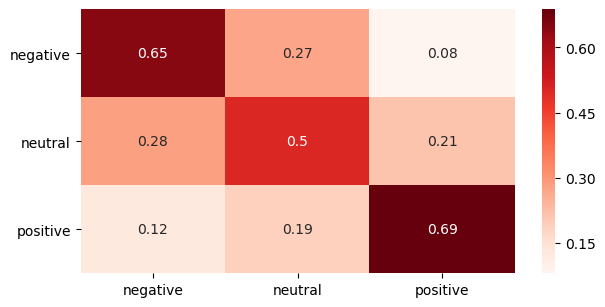

In [46]:
# Plotting confusion matrix
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize']=(7, 3.5)
fig, ax = plt.subplots()
#labels = ['negative', 'neutral', 'positive']
ticks = [0.5, 1.5, 2.5]
ax = sns.heatmap(df_cm, annot=True, cmap='Reds')
#ax.set_yticklabels(labels)
ax.set_yticks(ticks)
#ax.set_xticklabels(labels)
ax.tick_params(axis='y',rotation=0)
plt.ylim(ymin=3)
plt.ylim(ymax=0)
plt.show()

## Please note that negative and positive opinions are easily extiguishable but model often struggles with assessing if opinion is neutral or not, thus limiting categories only to positive or negative ones would probably greatly enhance model performance

In [47]:
# Defining losses and accuracies of the model
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
acc = history.history['acc']
loss = history.history['loss']
epoch_count = range(1, len(acc) + 1)

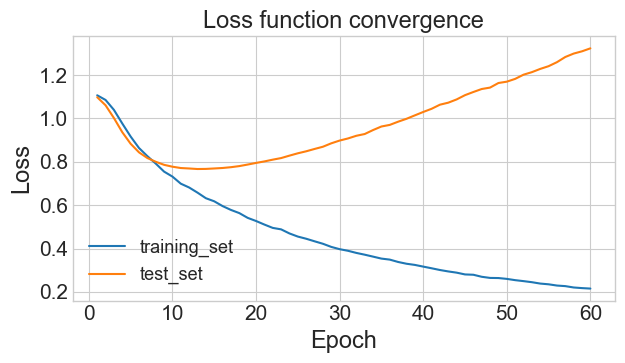

In [48]:
# Plotting loss function convergence
plt.style.use('seaborn-whitegrid')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Loss function convergence', fontsize = 17)
plt.ylabel('Loss', fontsize = 17)
plt.xlabel('Epoch', fontsize = 17)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['training_set', 'test_set'], fontsize=13)
plt.show()

## Model has an optimal performance around 15th epoch - further fitting of the model reduces loss function of the training set but reduces performance on the test set

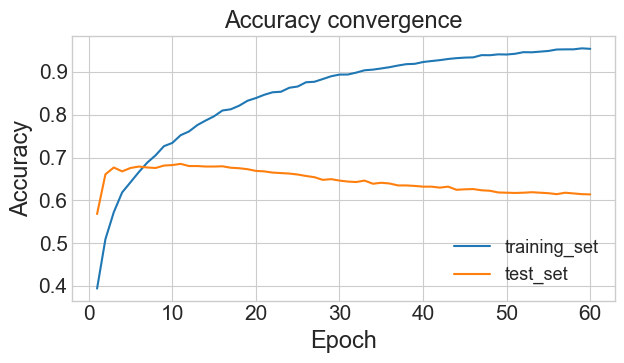

In [49]:
# Plotting accuracy convergence
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Accuracy convergence', fontsize = 17)
plt.ylabel('Accuracy', fontsize = 17)
plt.xlabel('Epoch', fontsize = 17)
plt.plot(epoch_count, acc)
plt.plot(epoch_count, val_acc)
plt.legend(['training_set', 'test_set'], fontsize=13)
plt.show()

## Even though the accuracy on the training set gadually increase over time, performance on the test set data is similar since 15th epoch up until the last one, what suggests that the given model is overfitted; considering confusion matrix results, it is clear that model tends to fail in assessing whether the given opinion is neutral or not